In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import copy
import os
import random
import math as math
import matplotlib.pylab as plt #Typically matplotlib.pylab is imported as plt (shortened name)
import pdb
from scipy.optimize import minimize
import shutil
import csv
from MyLatexFunctions_SocialLearning import * 
from itertools import permutations 
from itertools import combinations
import csv


import networkx as nx

In [2]:
datafolder = "..\\RawData\\Session_Formal"
datafolder2 = "..\\ImportedData\\"
outputfolder = "..\\Output_Figures\\" 


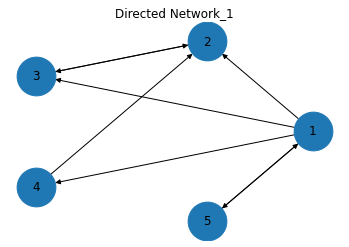

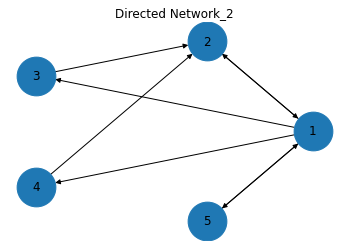

In [3]:
network = ["c1","c2"]
Alldata =  pd.DataFrame()
for i in range(1,3):
    data = pd.read_csv("..\\ImportedData\\network_c"+str(i)+".csv", sep=",", header=0)
    #data.columns = [ "from", "to" ]
    data["network"] = i
    Alldata = Alldata.append(data)

    
for i in range(1,3):
    # Build your graph. Note that we use the DiGraph function to create the graph!
    G=nx.from_pandas_edgelist(Alldata[Alldata.network==i], 'from', 'to', create_using=nx.DiGraph() )

    # Make the graph
    f1 = plt.figure()
    plt.title("Directed Network_"+str(i))
    nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_size=1500, alpha=1, arrows=True) 
    plt.show()

In [18]:
data  = pd.read_csv(datafolder2+"DataAnalysis_v4_EmpiricalOptimalDecisionTurn.csv")
data.columns

Index(['subject_id', 'subject_idnum', 'pcode', 'session', 'network_type',
       'waiting_cost', 'round_id', 'pid_in_session', 'ppayoff', 'pid_ingroup',
       'p_payoff', 'p_secspent', 'p_currentball', 'p_node', 'p_period',
       'p_lastinforset', 'p_currentinforset', 'p_history', 'p_time_on_page',
       'p_guessedurn', 'g_id', 'g_period', 'g_trueurn', 'g_round', 'g_match',
       'prnd1playerid_in_group', 'prnd1playerpayoff', 'prnd1playerpayoff_list',
       'prnd1groupid_in_subsession', 'prnd1subsessionround_number',
       'id_in_group', 'payoff', 'date', 'app', 'prnd1playerpayoff_total',
       'pay_sig1', 'pay_sig2', 'pay_sig3', 'pay_sig4', 'bid_a', 'bid_b',
       'bid_c', 'bid_d', 'bid_e', 'treatment', 'treatment_degree1',
       'prediction', 'prediction_acc', 'prediction_welfare', 'in_degree',
       'out_degree', 'in_degree_m', 'max_turn', 'wait2long', 'min_turn',
       'wait2short', 'rational', 'Know_network', 'Know_prob', 'in_degree_1',
       'Settle1', 'Settle_sum', '

In [19]:
def EmpiricalOptimal(row):
    fit = 0
    if row['network_type']=='a':
        if row['p_node'] == 'A' or row['p_node']=='E':
            fit = row['p_period']==0
        elif row['p_node'] == 'D':
            fit = row['p_period']==0
            if row['A_period']==0 and row['waiting_cost']=='L':
                fit = row['p_period']==1
            elif row['A_period']>=1 and row['waiting_cost']=='L':
                fit = row['p_period']==2
        elif row['p_node'] == 'C':
            if (row['A_period']==0 or row['B_period']==0) and row['waiting_cost']=='L':
                fit = row['p_period']==1
            elif row['waiting_cost']=='H':
                fit = row['p_period']==1
            elif (row['A_period']>=1 and row['B_period']>=1) and row['waiting_cost']=='L':
                fit = row['p_period']==2
        elif row['p_node'] == 'B':
            if (row['A_period']==0 and row['waiting_cost']=='L') or row['waiting_cost']=='H' :
                fit = row['p_period']==1
            elif row['A_period']>=1  and row['waiting_cost']=='L':
                fit = row['p_period']==2
                
    if row['network_type']=='b':
        if row['p_node'] == 'C' or  row['p_node'] == 'D' or row['p_node']=='E':
            if row['waiting_cost']=='H' or ( row['waiting_cost']=='L' and row['A_period']==0):
                fit = row['p_period']==0
            elif  row['waiting_cost']=='L' and row['A_period']==0:
                fit = row['p_period']==1
            elif row['waiting_cost']=='L' and (row['A_period']>=1 or row['B_period']==0):
                fit = row['p_period']==2
            elif row['waiting_cost']=='L' and (row['A_period']>=2 and row['B_period']>=1):
                fit = row['p_period']==3
        elif row['p_node'] == 'A' :
            if row['waiting_cost']=='H' or ( row['waiting_cost']=='L' and row['B_period']==0):
                fit = row['p_period']==1
            elif row['waiting_cost']=='L' and row['B_period']>=1 :
                fit = row['p_period']==2
        elif row['p_node'] == 'B' :
            if row['waiting_cost']=='H' or ( row['waiting_cost']=='L' and row['A_period']==0):
                fit = row['p_period']==1
            elif row['waiting_cost']=='L' and row['A_period']>=1 :
                fit = row['p_period']==2    
    return fit 

In [20]:
def EmpiricalOptimal_u(row):
    # This is to define the underwait rules
    fit = 0
    if row['network_type']=='a':
        if row['p_node'] == 'A' or row['p_node']=='E':
#             fit = row['p_period']==0
            fit = np.nan
        elif row['p_node'] == 'D':
#             fit = row['p_period']==0
            fit = np.nan
            if row['A_period']==0 and row['waiting_cost']=='L':
                fit = np.nan
            elif row['A_period']>=1 and row['waiting_cost']=='L' and row['p_period']==1:
                fit = 1 # A very restrictive case of underwaiting: with wrong belief and have waited for 1 turn
        elif row['p_node'] == 'C':
            if (row['A_period']==0 or row['B_period']==0) and row['waiting_cost']=='L':
                fit = row['p_period']<1
            elif row['waiting_cost']=='H':
                fit = row['p_period']<1
            elif (row['A_period']>=1 and row['B_period']>=1) and row['waiting_cost']=='L':
                fit = row['p_period']<2
        elif row['p_node'] == 'B':
            if (row['A_period']==0 and row['waiting_cost']=='L') or row['waiting_cost']=='H' :
                fit = row['p_period']<1
            elif row['A_period']>=1  and row['waiting_cost']=='L':
                fit = row['p_period']<2
                
    if row['network_type']=='b':
        if row['p_node'] == 'C' or  row['p_node'] == 'D' or row['p_node']=='E':
            if row['waiting_cost']=='H' or ( row['waiting_cost']=='L' and row['A_period']==0):
                fit = np.nan
            elif  row['waiting_cost']=='L' and row['A_period']==0:
                fit = row['p_period']<1
            elif row['waiting_cost']=='L' and (row['A_period']>=1 or row['B_period']==0):
                fit = row['p_period']<2
            elif row['waiting_cost']=='L' and (row['A_period']>=2 and row['B_period']>=1):
                fit = row['p_period']<3
        elif row['p_node'] == 'A' :
            if row['waiting_cost']=='H' or ( row['waiting_cost']=='L' and row['B_period']==0):
                fit = row['p_period']<1
            elif row['waiting_cost']=='L' and row['B_period']>=1 :
                fit = row['p_period']<2
        elif row['p_node'] == 'B' :
            if row['waiting_cost']=='H' or ( row['waiting_cost']=='L' and row['A_period']==0):
                fit = row['p_period']<1
            elif row['waiting_cost']=='L' and row['A_period']>=1 :
                fit = row['p_period']<2    
    return fit 

In [21]:
def EmpiricalOptimal_o(row):
    fit = 0
    if row['network_type']=='a':
        if row['p_node'] == 'A' or row['p_node']=='E':
            fit = row['p_period']>0
        elif row['p_node'] == 'D':
            fit = row['p_period']>0
            if row['A_period']==0 and row['waiting_cost']=='L':
                fit = row['p_period']>1
            elif row['A_period']>=1 and row['waiting_cost']=='L':
                fit = row['p_period']>2
        elif row['p_node'] == 'C':
            if (row['A_period']==0 or row['B_period']==0) and row['waiting_cost']=='L':
                fit = row['p_period']>1
            elif row['waiting_cost']=='H':
                fit = row['p_period']>1
            elif (row['A_period']>=1 and row['B_period']>=1) and row['waiting_cost']=='L':
                fit = row['p_period']>2
        elif row['p_node'] == 'B':
            if (row['A_period']==0 and row['waiting_cost']=='L') or row['waiting_cost']=='H' :
                fit = row['p_period']>1
            elif row['A_period']>=1  and row['waiting_cost']=='L':
                fit = row['p_period']>2
                
    if row['network_type']=='b':
        if row['p_node'] == 'C' or  row['p_node'] == 'D' or row['p_node']=='E':
            if row['waiting_cost']=='H' or ( row['waiting_cost']=='L' and row['A_period']==0):
                fit = row['p_period']>0
            elif  row['waiting_cost']=='L' and row['A_period']==0:
                fit = row['p_period']>1
            elif row['waiting_cost']=='L' and (row['A_period']>=1 or row['B_period']==0):
                fit = row['p_period']>2
            elif row['waiting_cost']=='L' and (row['A_period']>=2 and row['B_period']>=1):
                fit = row['p_period']>3
        elif row['p_node'] == 'A' :
            if row['waiting_cost']=='H' or ( row['waiting_cost']=='L' and row['B_period']==0):
                fit = row['p_period']>1
            elif row['waiting_cost']=='L' and row['B_period']>=1 :
                fit = row['p_period']>2
        elif row['p_node'] == 'B' :
            if row['waiting_cost']=='H' or ( row['waiting_cost']=='L' and row['A_period']==0):
                fit = row['p_period']>1
            elif row['waiting_cost']=='L' and row['A_period']>=1 :
                fit = row['p_period']>2    
    return fit 

In [22]:
data['Empirical_Optimal']= data.apply(EmpiricalOptimal, axis=1)
data['Empirical_UnderWait']= data.apply(EmpiricalOptimal_u, axis=1)
data['Empirical_OverWait']= data.apply(EmpiricalOptimal_o, axis=1)

In [23]:
data.columns

Index(['subject_id', 'subject_idnum', 'pcode', 'session', 'network_type',
       'waiting_cost', 'round_id', 'pid_in_session', 'ppayoff', 'pid_ingroup',
       'p_payoff', 'p_secspent', 'p_currentball', 'p_node', 'p_period',
       'p_lastinforset', 'p_currentinforset', 'p_history', 'p_time_on_page',
       'p_guessedurn', 'g_id', 'g_period', 'g_trueurn', 'g_round', 'g_match',
       'prnd1playerid_in_group', 'prnd1playerpayoff', 'prnd1playerpayoff_list',
       'prnd1groupid_in_subsession', 'prnd1subsessionround_number',
       'id_in_group', 'payoff', 'date', 'app', 'prnd1playerpayoff_total',
       'pay_sig1', 'pay_sig2', 'pay_sig3', 'pay_sig4', 'bid_a', 'bid_b',
       'bid_c', 'bid_d', 'bid_e', 'treatment', 'treatment_degree1',
       'prediction', 'prediction_acc', 'prediction_welfare', 'in_degree',
       'out_degree', 'in_degree_m', 'max_turn', 'wait2long', 'min_turn',
       'wait2short', 'rational', 'Know_network', 'Know_prob', 'in_degree_1',
       'Settle1', 'Settle_sum', '

In [24]:
data = data[['subject_idnum', 'round_id', 'Empirical_Optimal', 'Empirical_UnderWait', 'Empirical_OverWait' ]]

In [26]:
data

subject_idnum  round_id  Empirical_Optimal Empirical_UnderWait  \
0                83        16               True               False   
1                53         4              False                 NaN   
2                28         8              False                 NaN   
3               122         3               True               False   
4                92        18               True               False   
...             ...       ...                ...                 ...   
3995             67         7              False                 NaN   
3996             99         8              False                True   
3997            127         5              False               False   
3998            610        17              False                 NaN   
3999             69        13               True                 NaN   

      Empirical_OverWait  
0                  False  
1                   True  
2                   True  
3                  False  
4                  False  
...                  ...  
3995                True  
3996               False  
3997                True  
3998                True  
3999               False  

[4000 rows x 5 columns]

In [25]:
data.to_csv(datafolder2+"00_Empricial_Optimal_Data.csv", sep=",")